In [0]:
#Import libraries
!pip install tensorflow
!pip install Keras-Preprocessing
!pip install networkx
from pyspark.sql.functions import col, sum, when, split, regexp_replace, explode, length, size, mean, desc
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
!pip install tqdm
from tqdm import tqdm
!pip install nltk
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
!pip install string
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import networkx as nx

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade 

In [0]:
#import the package we just installed
!pip install graphframes
import graphframes
from graphframes import *
#import data types - All data types of Spark SQL are located in the package of pyspark.sql.types
from pyspark.sql.types import *
#row can be used to create a row object by using named arguments
from pyspark.sql import Row
from pyspark.sql.functions import col

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6a3def5c-efff-4885-a79d-a2cba4124234/bin/python -m pip install --upgrade pip' command.


In [0]:
#Preprocessing imports
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Out[81]: True

Import dataset and analyse it

In [0]:
# Load data into the big data cluster as a dataframe
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/bernardo.machado4@protonmail.com/cryptonews.csv")
df.printSchema() 

root
 |-- date: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- source: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)



In [0]:
#Print all the database
df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph|   bitcoin|Ether has broken ...|ETH hits 7-month ...|https://cointeleg...|
|2023-04-05 01:09:52|{'class': 'positi...|CoinTelegraph|   bitcoin|With a new quarte...|Marathon Digital ...|https://cointeleg...|
|2023-04-04 23:49:00|{'class': 'positi...| CryptoPotato|   altcoin|The stablecoin B

In [0]:
row_count = df.count()
print(row_count)

18543


In [0]:
#Find source with most entries
df.groupBy('source').count().orderBy('count', ascending = 0).show()

+-------------+-----+
|       source|count|
+-------------+-----+
|CoinTelegraph| 8675|
|   CryptoNews| 5261|
| CryptoPotato| 4607|
+-------------+-----+



In [0]:
#Find most comun subject
df.groupBy('subject').count().orderBy('count', ascending = 0).show()

+----------+-----+
|   subject|count|
+----------+-----+
|   bitcoin| 6439|
|   altcoin| 5264|
|blockchain| 3445|
|  ethereum| 1524|
|       nft| 1164|
|      defi|  707|
+----------+-----+



In [0]:
"""We see we have more data the the sentiment evaluation (polarity and subjectivity) but we decided to ignore them and just use the sentiment in our ML apporoach"""
df.select("sentiment").show(truncate=False)

+--------------------------------------------------------------+
|sentiment                                                     |
+--------------------------------------------------------------+
|{'class': 'negative', 'polarity': -0.03, 'subjectivity': 0.2} |
|{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}    |
|{'class': 'negative', 'polarity': -0.04, 'subjectivity': 0.31}|
|{'class': 'positive', 'polarity': 0.07, 'subjectivity': 0.23} |
|{'class': 'positive', 'polarity': 0.4, 'subjectivity': 0.4}   |
|{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}    |
|{'class': 'positive', 'polarity': 0.27, 'subjectivity': 0.47} |
|{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}    |
|{'class': 'negative', 'polarity': -0.1, 'subjectivity': 0.4}  |
|{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}    |
|{'class': 'positive', 'polarity': 0.25, 'subjectivity': 0.25} |
|{'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}    |
|{'class': 'positive', 'p

In [0]:
#Create a new column with only the sentiment information
df = df.withColumn("OnlySentiment", split(df.sentiment, " ").getItem(1))
df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|  'negative',|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|   'neutral',|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph|   bitcoin|Ether has broken ...|ETH hits 7-month ...|https://cointeleg...|  'negative',|
|2023-04-05 01:09:52|{'class': 'positi...|CoinTelegraph|   bitcoin|With a new quarte...|Marathon Digital ...|https://cointeleg...|

In [0]:
#Clean the string in column OnlySentiment
df = df.withColumn("OnlySentiment", split(df.OnlySentiment, "'").getItem(1))
df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|     negative|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|      neutral|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph|   bitcoin|Ether has broken ...|ETH hits 7-month ...|https://cointeleg...|     negative|
|2023-04-05 01:09:52|{'class': 'positi...|CoinTelegraph|   bitcoin|With a new quarte...|Marathon Digital ...|https://cointeleg...|

In [0]:
#Analyse of the general sentiment
df.groupBy('OnlySentiment').count().orderBy('count', ascending=0).show()

+-------------+-----+
|OnlySentiment|count|
+-------------+-----+
|     positive| 8296|
|      neutral| 6417|
|     negative| 3830|
+-------------+-----+



In [0]:
#Create a new column with integers to use in a machine learning model
df = df.withColumn("IntSentiment", when(df.OnlySentiment == "negative", 0)
                                        .when(df.OnlySentiment == "positive", 1)
                                        .otherwise(3))

df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|IntSentiment|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|     negative|           0|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|      neutral|           3|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph|   bitcoin|Ether has broken ...|ETH hits 7-month ...|https://cointeleg...|     negative|           0|
|2023-04-05 01:09:52|{'class': 'positi...|CoinTelegr

In [0]:
df.printSchema() #confirm data in IntSentiment is an integer

root
 |-- date: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- source: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- OnlySentiment: string (nullable = true)
 |-- IntSentiment: integer (nullable = false)



In [0]:
#Find the most comun sentiment in March 2023
df.where(col("date").between("2023-03-01", "2023-03-31")).show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|IntSentiment|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+
|2023-03-30 23:51:00|{'class': 'positi...| CryptoPotato|   altcoin|The proposal is e...|New Binance Smart...|https://cryptopot...|     positive|           1|
|2023-03-30 23:26:00|{'class': 'negati...|   CryptoNews|   altcoin|Bitcoin, the worl...|Bitcoin Price Pre...|https://cryptonew...|     negative|           0|
|2023-03-30 23:03:00|{'class': 'positi...|   CryptoNews|   altcoin|Bitcoin defies US...|Best Crypto to Bu...|https://cryptonew...|     positive|           1|
|2023-03-30 22:03:00|{'class': 'neutra...| CryptoPot

In [0]:
#Create a new column with a list of words from text column
df = df.withColumn("wordsDict", split(df.text, " "))
df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|IntSentiment|           wordsDict|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|     negative|           0|[The, compensatio...|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|      neutral|           3|[On-chain, analyt...|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph|   bitcoin|Ether has broken ...|ETH hits 7-month 

In [0]:
#Count the number of words of each row for  text column
df = df.withColumn("wordCount", size(df["wordsDict"]))
df.show()

+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+---------+
|               date|           sentiment|       source|   subject|                text|               title|                 url|OnlySentiment|IntSentiment|           wordsDict|wordCount|
+-------------------+--------------------+-------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+---------+
|2023-04-05 06:52:09|{'class': 'negati...|CoinTelegraph|      defi|The compensation ...|Allbridge to firs...|https://cointeleg...|     negative|           0|[The, compensatio...|       22|
|2023-04-05 06:19:00|{'class': 'neutra...| CryptoPotato|   bitcoin|On-chain analytic...|Bitcoin Hodl Patt...|https://cryptopot...|      neutral|           3|[On-chain, analyt...|       17|
|2023-04-05 05:09:44|{'class': 'negati...|CoinTelegraph

<Figure size 1296x864 with 0 Axes>

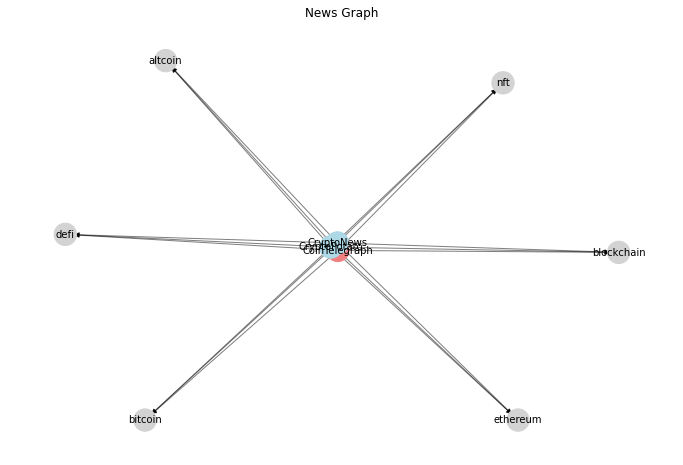

In [0]:
##Graphs
# Select the "text" and "IntSentiment" columns
graph_df = df.select("source","subject","title", "OnlySentiment")


# Convert the DataFrame to a Pandas DataFrame for convenience
graph_pd = graph_df.toPandas()

# Create a vertices DataFrame
verticesList = pd.concat([graph_pd['source'], graph_pd['subject']], ignore_index=True).unique()
verticesList = pd.DataFrame(verticesList, columns=['id'])

# Create an edges DataFrame
edgeDataList = graph_pd[['source', 'subject', 'OnlySentiment']].rename(columns={'source': 'src', 'subject': 'dst'})

# Create a new directed graph
G = nx.DiGraph()

# Add vertices to the graph
G.add_nodes_from(verticesList['id'])

# Add edges to the graph
G.add_edges_from(edgeDataList[['src', 'dst']].values)

# Draw the graph
pos = nx.spring_layout(G)

# Draw the graph
pos = nx.spring_layout(G, scale=0.5)  # Adjust the scale for zooming out

plt.figure(figsize=(18, 12))  # Increase the figure size for better visibility

# Create a dictionary to map sentiment to color
sentiment_colors = {
    'positive': 'lightgreen',
    'neutral': 'lightblue',
    'negative': 'lightcoral'
}

node_colors = []
for node in G.nodes:
    node_sentiment = graph_pd.loc[graph_pd['source'] == node, 'OnlySentiment']
    if not node_sentiment.empty:
        sentiment = node_sentiment.iloc[0]
        color = sentiment_colors.get(sentiment, 'lightgray')
        node_colors.append(color)
    else:
        node_colors.append('lightgray')

plt.figure(figsize=(12, 8))

# Draw nodes with different colors and labels
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes}, font_size=10, font_color='black')

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.5)

# Customize plot appearance
plt.title('News Graph')
plt.axis('off')

# Show the graph
plt.show()

Apply RDDs

In [0]:
# Convert Dataset to RDD
rdd = df.rdd

# Extract the desired column
text_rdd = rdd.map(lambda row: row.text)

# Split lines into words
words_rdd = text_rdd.flatMap(lambda line: line.split(" "))

# Count the occurrences of each word
word_counts = words_rdd.countByValue()

# print the word count
for word, count in word_counts.items():
    print(f"{word}: {count}")

The: 4631
compensation: 8
process: 50
is: 4732
expected: 118
to: 12112
start: 124
next: 303
week,: 104
starting: 59
with: 2727
users: 491
who: 281
had: 261
funds: 305
on: 3185
the: 19868
bridge: 62
“shortly: 1
before: 262
shutdown.”: 1
On-chain: 30
analytics: 37
revealed: 126
a: 8408
sentiment: 75
shift: 29
for: 3802
BTC: 1006
holders,: 5
suggesting: 38
cycle: 15
inflection: 5
point: 74
could: 1107
be: 1834
occurring.: 1
Ether: 84
has: 3597
broken: 19
$1,900: 1
resistance: 208
level: 199
first: 413
time: 326
in: 7030
months: 143
and: 9011
currently: 165
sitting: 8
above: 530
$1,911.: 1
With: 199
new: 1281
quarterly: 16
production: 18
record,: 2
Marathon: 13
Digital: 137
now: 498
track: 35
meet: 26
its: 2654
mid-year: 1
target: 48
of: 9703
23: 4
exahashes.: 1
stablecoin: 202
BTG: 2
Dol: 1
will: 1864
supposedly: 60
become: 263
23rd: 1
token: 389
available: 76
crypto: 3521
platform: 336
Mynt.: 1
As: 257
concerns: 78
about: 537
regulatory: 188
crackdown: 35
US: 470
heat: 15
up,: 13
flows: 

In [0]:
# Sort the word count in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the word count in descending order
for word, count in sorted_word_counts:
    print(f"{word}: {count}")
    

the: 19868
to: 12112
of: 9703
and: 9011
a: 8408
in: 7030
is: 4732
The: 4631
for: 3802
has: 3597
crypto: 3521
that: 3487
on: 3185
Bitcoin: 2776
with: 2727
as: 2720
its: 2654
are: 2351
price: 2237
by: 2046
will: 1864
be: 1834
from: 1667
have: 1563
it: 1456
an: 1326
market: 1309
at: 1284
new: 1281
but: 1263
their: 1177
could: 1107
USD: 1100
Ethereum: 1049
over: 1014
BTC: 1006
more: 1001
this: 922
after: 897
been: 828
cryptocurrency: 820
NFT: 819
digital: 803
said: 759
trading: 752
A: 748
not: 744
million: 737
blockchain: 718
was: 709
: 680
up: 663
than: 629
can: 622
into: 591
investors: 588
exchange: 575
some: 559
out: 558
about: 537
above: 530
which: 523
while: 508
FTX: 500
his: 499
now: 498
users: 491
one: 491
past: 484
CEO: 474
may: 472
US: 470
last: 470
they: 454
or: 449
still: 434
DeFi: 426
your: 422
assets: 418
first: 413
support: 409
financial: 404
other: 402
recent: 397
below: 396
most: 394
Binance: 393
all: 391
token: 389
major: 378
down: 377
how: 376
asset: 375
NFTs: 370
latest:

In [0]:
#Remove punctuation to find the tru most comun words
def remove_punctuation(text):
    # Use regular expression to replace punctuation with empty string
    return re.sub(r'[^\w\s]', '', text)

clean_rdd = words_rdd.map(remove_punctuation).map(lambda x: x.lower())

# Count the occurrences of each word and sorte them in descending order
clean_word_counts = clean_rdd.countByValue()
sorted_clean_word_counts = sorted(clean_word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the word count in descending order
for word, count in sorted_word_counts:
    print(f"{word}: {count}")

the: 19868
to: 12112
of: 9703
and: 9011
a: 8408
in: 7030
is: 4732
The: 4631
for: 3802
has: 3597
crypto: 3521
that: 3487
on: 3185
Bitcoin: 2776
with: 2727
as: 2720
its: 2654
are: 2351
price: 2237
by: 2046
will: 1864
be: 1834
from: 1667
have: 1563
it: 1456
an: 1326
market: 1309
at: 1284
new: 1281
but: 1263
their: 1177
could: 1107
USD: 1100
Ethereum: 1049
over: 1014
BTC: 1006
more: 1001
this: 922
after: 897
been: 828
cryptocurrency: 820
NFT: 819
digital: 803
said: 759
trading: 752
A: 748
not: 744
million: 737
blockchain: 718
was: 709
: 680
up: 663
than: 629
can: 622
into: 591
investors: 588
exchange: 575
some: 559
out: 558
about: 537
above: 530
which: 523
while: 508
FTX: 500
his: 499
now: 498
users: 491
one: 491
past: 484
CEO: 474
may: 472
US: 470
last: 470
they: 454
or: 449
still: 434
DeFi: 426
your: 422
assets: 418
first: 413
support: 409
financial: 404
other: 402
recent: 397
below: 396
most: 394
Binance: 393
all: 391
token: 389
major: 378
down: 377
how: 376
asset: 375
NFTs: 370
latest:

In [0]:
#Word count with RDD

# Convert DataFrame to RDD and calculate sum of words for each row
word_count_rdd = df.select("text").rdd.map(lambda row: (row[0], len(row[0].split(" "))))
text_list = list()
count_list = list()

# Print the sum of words for each row
for row in word_count_rdd.collect():
    print(f"Text: {row[0]} <---> Word Count: {row[1]}")
    text_list.append(row[0])
    count_list.append(row[1])

Text: The compensation process is expected to start next week, starting with users who had funds on the bridge “shortly before the shutdown.” <---> Word Count: 22
Text: On-chain analytics revealed a sentiment shift for BTC holders, suggesting a cycle inflection point could be occurring. <---> Word Count: 17
Text: Ether has broken the $1,900 resistance level for the first time in months and is currently sitting above $1,911. <---> Word Count: 19
Text: With a new quarterly production record, Marathon Digital is now on track to meet its mid-year target of 23 exahashes. <---> Word Count: 20
Text: The stablecoin BTG Dol will supposedly become the 23rd token available on the crypto platform Mynt. <---> Word Count: 16
Text: As concerns about a regulatory crackdown in the US heat up, flows could head disproportionately towards the one cryptocurrency that seems to be in the regulatory all-clear - Bitcoin. <---> Word Count: 29
Text: Amid concerns of a potential recession due to declining job ope

In [0]:
print(f"The biggest string have {max(count_list)} words")
print(f"The lowest string have {min(count_list)} words")

The biggest string have 87 words
The lowest string have 4 words


In [0]:
#Count all word of text column using an RDD
word_count_rdd.reduce(lambda x, y : ("Total", x[1]+y[1]))

Out[102]: ('Total', 404280)

Apply a machine learning model to predict sentiment of our news

In [0]:
#for our ML approach we decide to use Pandas, so we made the appropriate transformation
X=df.toPandas()
X=X[["text","IntSentiment","wordCount"]]
X

,text,IntSentiment,wordCount
0,The compensation process is expected to start ...,0,22
1,On-chain analytics revealed a sentiment shift ...,3,17
2,"Ether has broken the $1,900 resistance level f...",0,19
3,"With a new quarterly production record, Marath...",1,20
4,The stablecoin BTG Dol will supposedly become ...,1,16
...,...,...,...
18538,Cream Finance (CREAM) suffered another flash l...,3,8
18539,Banque de France disclosed the results of its ...,1,20
18540,Advancing its project to become \x9caÂ\xa0meta...,1,17
18541,Chinese companies are still topping the blockc...,3,9


In [0]:
#Data Split
df_train, df_test = train_test_split(X, test_size=0.25, random_state=42)

In [0]:
stop = set(stopwords.words('english'))
# Remove stop words
#stop_words = set(stopwords.words('english'))

In [0]:
#function to clear our text
#it deletes stop words, puts everything in lowercase. Finally it removes numbers, punctuation and links

def clean(text_list):
    
    updates = []
    
    
    for j in tqdm(text_list):
        
        text = j      

        #Remove Links (they don't add information regarding sentiment)
        text = " ".join([word for word in text.split() if "https" not in word])    
             
        tokens = word_tokenize(text)
        tagged = nltk.pos_tag(tokens)
        entities = nltk.ne_chunk(tagged, binary=False)              
        
        #LOWERCASE TEXT
        text = text.lower()

        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
            
        updates.append(text)
        
    return updates

In [0]:
#applying the function to our train data set
df_train['text'] = df_train['text'].astype(str)
updates = clean(df_train['text'])

 43%|████▎     | 6022/13907 [00:51<01:09, 11

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 13907/13907 [01:58<00:00, 117.25it/s]


In [0]:
#joining all the words (cleaned)
all_words_clean = ' '.join(updates).split()

In [0]:
#how many words we end up with
len(all_words_clean)

Out[109]: 190022

In [0]:
#frequency of each word
freq_clean = pd.Series(all_words_clean).value_counts()

In [0]:
freq_clean.sort_values(ascending=False)[0:100]

Out[111]: crypto        3340
bitcoin       2774
price         1751
market        1351
blockchain    1106
              ... 
near           243
largest        241
many           239
around         239
report         236
Length: 100, dtype: int64

In [0]:
df_train["text_clean"]=updates
df_train["word count clean"]= df_train['text_clean'].apply(lambda x: len(str(x).split(" ")))

In [0]:
#4 - Feature Engineering
#   Bag of Words

In [0]:
#vectorizing our words with the bag of words method
bow = CountVectorizer(binary=True)
X = bow.fit_transform(df_train["text_clean"])
y = np.array(df_train['IntSentiment'])

In [0]:
#applying a KNN model 
modelknn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
modelknn.fit(X,y)

Out[115]: KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [0]:
#repeting for the test set
df_test['Cleaned Text'] = clean(df_test['text'])
X_test = bow.transform(df_test['Cleaned Text'])
y_test = np.array(df_test['IntSentiment'])
y_pred = modelknn.predict(X_test)

100%|██████████| 4636/4636 [00:39<00:00, 116.67it/s]


In [0]:
#printing the results
labels = {"Negative":0, "Positive":1, "Neutral":3}
print(classification_report(y_pred, y_test, target_names = labels.keys()))
report_1=classification_report(y_pred, y_test, target_names = labels.keys())

              precision    recall  f1-score   support

    Negative       0.25      0.51      0.33       457
    Positive       0.69      0.59      0.63      2432
     Neutral       0.57      0.53      0.55      1747

    accuracy                           0.56      4636
   macro avg       0.50      0.54      0.50      4636
weighted avg       0.60      0.56      0.57      4636



In [0]:
#defining function for a confusion matrix
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()



In [0]:
#creating confusion matrix
confusion_matrix(y_pred, y_test)

Out[119]: array([[ 232,  130,   95],
       [ 404, 1429,  599],
       [ 309,  514,  924]])

<command-2503190786447543>:40: UserWarning: Attempting to set identical bottom == top == 2.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


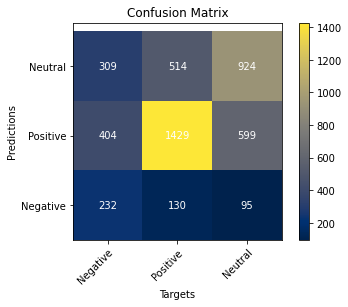

In [0]:
#plotting confusion matrix
plot_cm(confusion_matrix(y_pred, y_test), labels.keys())

In [0]:
###### Logistic Regression Model

In [0]:
#creating the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X,y)

/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Out[122]: LogisticRegression(random_state=0)

In [0]:
#applying the model to the 
lr_pred = lr.predict(X_test)

In [0]:
#getting the results
labels = {"Negative":0, "Positive":1, "Neutral":3}
print(classification_report(lr_pred, y_test, target_names = labels.keys()))
report_2=classification_report(lr_pred, y_test, target_names = labels.keys())

              precision    recall  f1-score   support

    Negative       0.62      0.75      0.68       790
    Positive       0.80      0.84      0.82      1990
     Neutral       0.86      0.75      0.80      1856

    accuracy                           0.79      4636
   macro avg       0.76      0.78      0.77      4636
weighted avg       0.80      0.79      0.79      4636



<command-2503190786447543>:40: UserWarning: Attempting to set identical bottom == top == 2.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


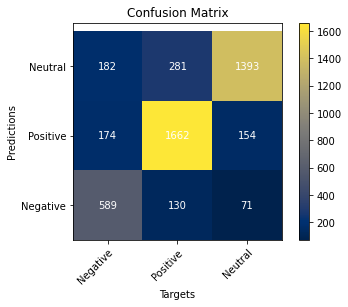

In [0]:
#plotting the confusion matrix
plot_cm(confusion_matrix(lr_pred, y_test), labels.keys())